# Lecture 6: UNet

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random 

random.seed(42)
torch.manual_seed(42)


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Load segmentation data

In [7]:
# Load ISBI 2012 data
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from PIL import Image
import os

images_dir = "/home/glouppe/isbi-datasets/data/images/"
labels_dir = "/home/glouppe/isbi-datasets/data/labels/"

image_files = sorted(os.listdir(images_dir))
label_files = sorted(os.listdir(labels_dir))

In [28]:
# Crop and transforms
def random_crop(image, label, size=(128, 128)):
    i, j, h, w = transforms.RandomCrop.get_params(image, output_size=size)
    image = TF.crop(image, i, j, h, w)
    label = TF.crop(label, i, j, h, w)
    return image, label

image_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

# Load and process images and labels
N = 5000
X = []
Y = []

for _ in range(N):
    i = random.randint(0, len(image_files) - 1)

    image = Image.open(os.path.join(images_dir, image_files[i]))
    label = Image.open(os.path.join(labels_dir, label_files[i]))
    
    image, label = random_crop(image, label)
    image = image_transform(image)
    label = image_transform(label)
    
    X.append(image)
    Y.append(label)

# Stack tensors
X = torch.stack(X).to(device)
X = (X - X.mean()) / X.std()
Y = torch.stack(Y).to(device) 
Y = (Y < 0.5).float()

In [29]:
# Data loader
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(X, Y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

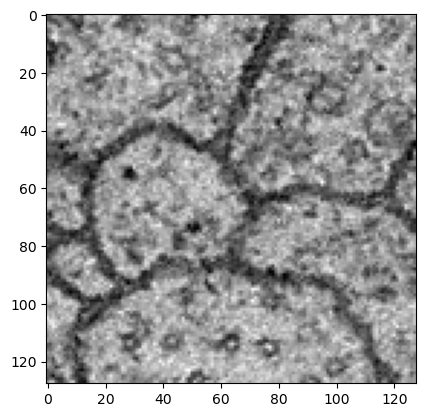

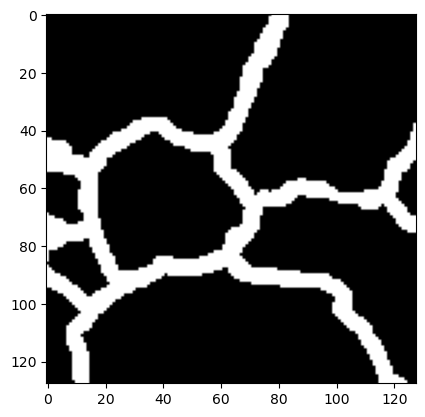

In [30]:
# Display images
i = random.randint(0, N)

plt.imshow(X[i].squeeze().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(Y[i].squeeze().cpu().numpy(), cmap="gray")
plt.show()

# UNet model

In [31]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU()
        )

    def forward(self, x):
        #print(f"Block: x.shape = {x.shape}")
        return self.block(x)
    
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = Block(in_channels, out_channels)
        self.down = nn.MaxPool2d(2)

    def forward(self, x):
        #print(f"Down: x.shape = {x.shape}")
        x = self.block(x)
        x_down = self.down(x)
        return x, x_down
    
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.block = Block(in_channels + out_channels, out_channels)

    def forward(self, x, skip):
        #print(f"Up: x.shape = {x.shape}, skip.shape = {skip.shape}")
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)   # !! test with and without skip connection
        x = self.block(x)
        return x

class TinyUnet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.down1 = Down(in_channels, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)

        self.middle = Block(256, 256)

        self.up3 = Up(256, 128)
        self.up2 = Up(128, 64)
        self.up1 = Up(64, out_channels)

    def forward(self, x):
        # x is (B, in_channels, H, W)
        x1, x = self.down1(x)  # x1 is (B, 64, H, W), x is (B, 64, H/2, W/2)
        x2, x = self.down2(x)  # x2 is (B, 128, H/2, W/2), x is (B, 128, H/4, W/4)
        x3, x = self.down3(x)  # x3 is (B, 256, H/4, W/4), x is (B, 256, H/8, W/8)
        x = self.middle(x)     # x is (B, 256, H/8, W/8)
        x = self.up3(x, x3)    # x is (B, 128, H/4, W/4)
        x = self.up2(x, x2)    # x is (B, 64, H/2, W/2)
        x = self.up1(x, x1)    # x is (B, out_channels, H, W)
        return x

net = TinyUnet(1, 1).to(device)

In [32]:
# Training loop
optimizer = torch.optim.AdamW(net.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(10):
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = net(x)
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}, loss = {loss.item()}")

Epoch 0, loss = 0.6939923763275146
Epoch 0, loss = 0.6908472180366516
Epoch 0, loss = 0.690630316734314
Epoch 0, loss = 0.6890716552734375
Epoch 0, loss = 0.6927927732467651
Epoch 0, loss = 0.6877669095993042
Epoch 0, loss = 0.6875215768814087
Epoch 0, loss = 0.6869797706604004
Epoch 0, loss = 0.6868256330490112
Epoch 0, loss = 0.6815001964569092
Epoch 0, loss = 0.6941444873809814
Epoch 0, loss = 0.6778177618980408
Epoch 0, loss = 0.6808199882507324
Epoch 0, loss = 0.6791274547576904
Epoch 0, loss = 0.6827077269554138
Epoch 0, loss = 0.6833736896514893
Epoch 0, loss = 0.6788080334663391
Epoch 0, loss = 0.680109977722168
Epoch 0, loss = 0.6778796315193176
Epoch 0, loss = 0.6742420792579651
Epoch 0, loss = 0.6699937582015991
Epoch 0, loss = 0.6783298254013062
Epoch 0, loss = 0.6690763831138611
Epoch 0, loss = 0.6665534973144531
Epoch 0, loss = 0.6719582080841064
Epoch 0, loss = 0.6692816019058228
Epoch 0, loss = 0.666208028793335
Epoch 0, loss = 0.6618723273277283
Epoch 0, loss = 0.66386

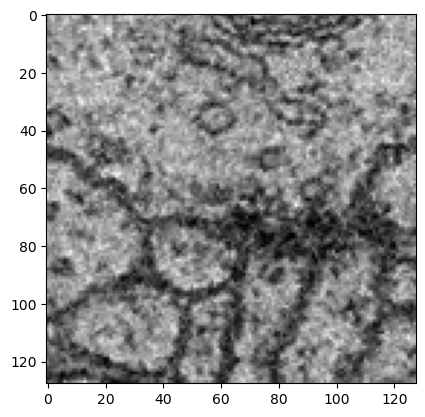

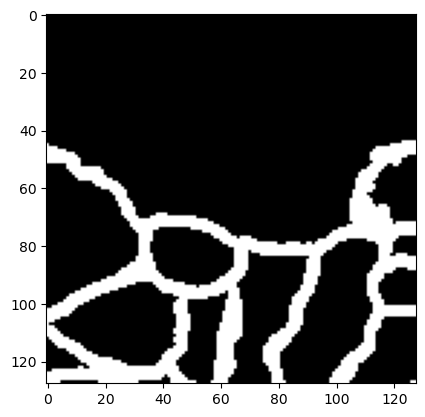

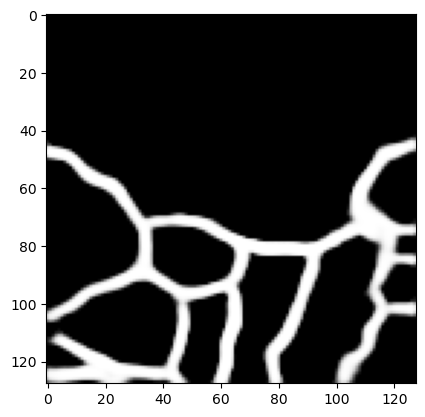

In [33]:
# Test 
x, y = next(iter(dataloader))
y_pred = net(x.to(device))
y_pred = F.sigmoid(y_pred)

plt.imshow(x[0].squeeze().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(y[0].squeeze().cpu().numpy(), cmap="gray")
plt.show()

plt.imshow(y_pred[0].squeeze().cpu().detach().numpy(), cmap="gray")
plt.show()